In [1]:
import torch
import os
from bmadx import M_ELECTRON
from bmadx.bmad_torch.track_torch import Beam
from bmadx.plot import plot_projections
import matplotlib.pyplot as plt
from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend

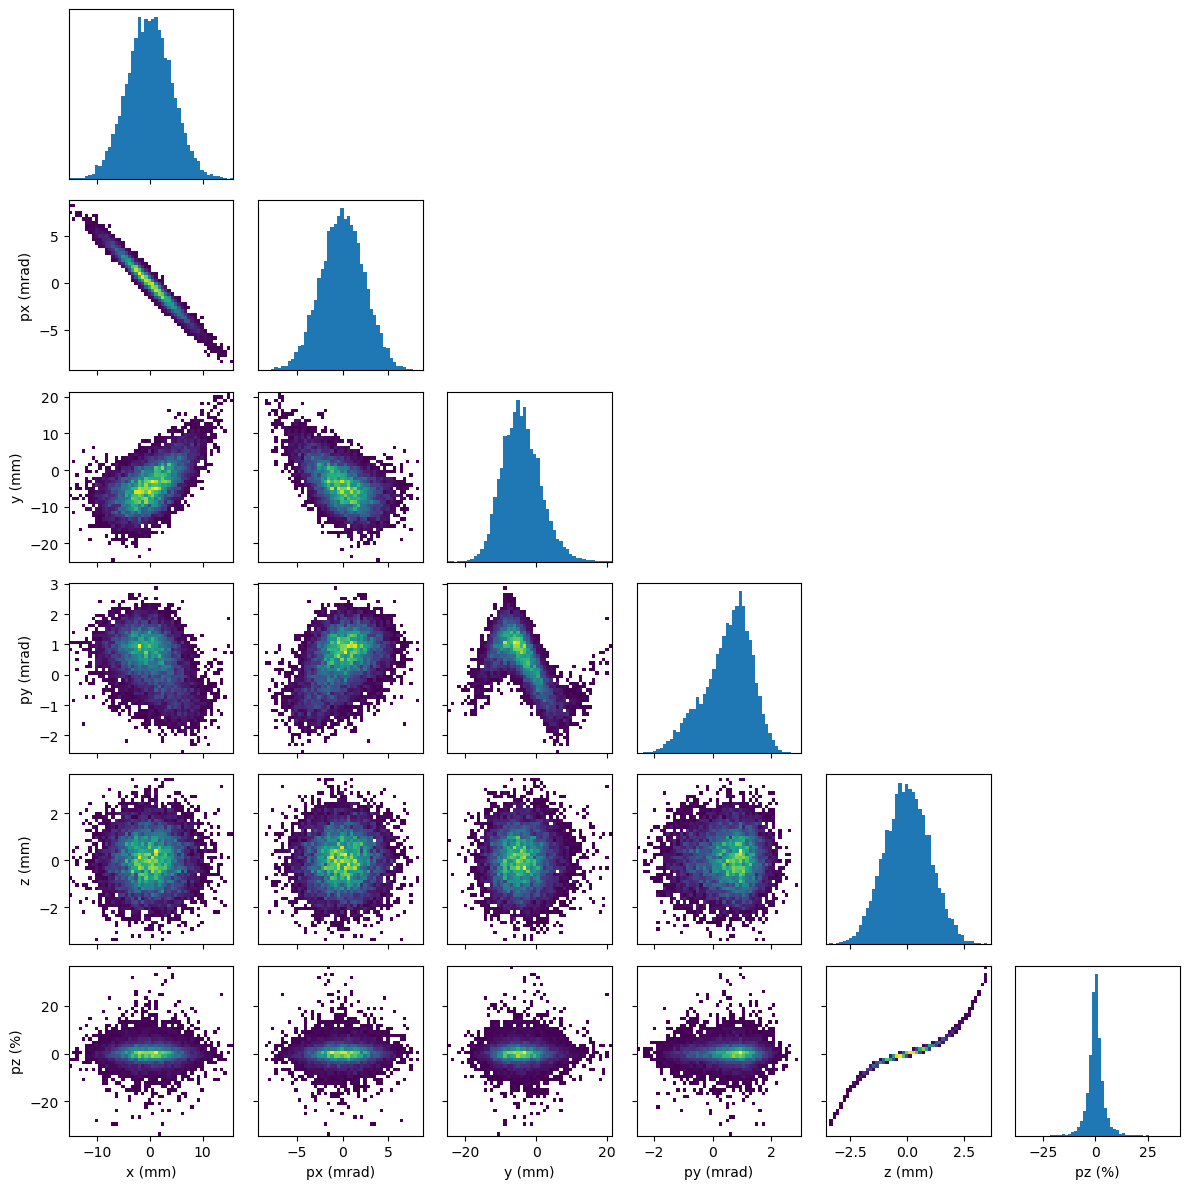

In [2]:
data_dir = 'data'

gt_beam = torch.load(os.path.join(data_dir, 'gt_beam.pt'))
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()

In [3]:
# generate initial beam
# - z geometric emittance of 1.0e-8 m-rad
cov = torch.eye(6) * 1.0e-8
# set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
# note minimum geometric emittance is 1e-7 m-rad
cov[0, 0] = 1.0e-3 ** 2
cov[1, 1] = 1.0e-4 ** 2
cov[2, 2] = 1.0e-3 ** 2
cov[3, 3] = 1.0e-4 ** 2

# Create torch particle beam
s = 0.0 # initial s
p0c = 43.36e6 # reference momentum in eV

# Initial beam distribution
n_particles = 100_000 # number of particles in beam
dist = torch.distributions.MultivariateNormal(loc = torch.zeros(6), 
                                              covariance_matrix = cov)
coords = dist.sample(torch.Size([n_particles]))
beam = gt_beam

In [4]:
def change_quadlet_params(lat, k1, k2, k3):
    lat.elements[0].K1.data = k1
    lat.elements[2].K1.data = k2
    lat.elements[4].K1.data = k3

def beamsize_quadlet(input_data):
    """
    calculate final beam sizes as a function of quadrupole strengths [k1,k2,k3]

    Parameters
    ----------
    input_data: dict with quad strengths

    Return
    ------
    dict with beamsizes
    """
    K = torch.tensor([input_data[f"k{i}"] for i in range(1, 4)])
    # create accelerator lattice object with one quad and a drift
    lattice = quadlet_tdc_bend(p0c, dipole_on=False)
    change_quadlet_params(lattice, *K)

    # propagate beam matrix
    final_beam = lattice(beam)
    std_x = final_beam.x.std()
    std_y = final_beam.y.std()

    total_size = torch.sqrt(std_x**2 + std_y**2)

    delta = torch.sqrt((std_x-0.01)**2 + (std_y-0.01)**2)


    return {
        "std_x": float(std_x),
        "std_y": float(std_y),
        "total_size": float(total_size),
        "delta": float(delta)
    }

In [5]:
from typing import Callable, Dict

import pandas as pd
from xopt import Evaluator, Xopt, VOCS
from xopt.generators import ExpectedImprovementGenerator
import numpy as np

/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def optimize_function(
        vocs: VOCS,
        evaluator_function: Callable,
        n_iterations: int = 5,
        n_initial: int = 5,
        generator_kwargs: Dict = None
) -> Xopt:
    """
    Function to minimize a given function using Xopt's ExpectedImprovementGenerator.

    Details:
    - Initializes BO with a set number of random evaluations given by `n_initial`
    - Raises errors if they occur during calls of `evaluator_function`
    - Runs the generator for `n_iteration` steps
    - Identifies and re-evaluates the best observed point

    Parameters
    ----------
    vocs: VOCS
        Xopt style VOCS object to describe the optimization problem

    evaluator_function : Callable
        Xopt style callable function that is evaluated during the optimization run.

    n_iterations : int, optional
        Number of optimization steps to run. Default: 5

    n_initial : int, optional
        Number of initial random samples to take before performing optimization
        steps. Default: 5

    generator_kwargs : dict, optional
        Dictionary passed to generator to customize Expected Improvement BO.

    Returns
    -------
    X : Xopt
        Xopt object containing the evaluator, generator, vocs and data objects.

    """

    # set up Xopt object
    generator_kwargs = generator_kwargs or {}
    beamsize_evaluator = Evaluator(function=evaluator_function)
    generator = ExpectedImprovementGenerator(vocs=vocs, **generator_kwargs)

    X = Xopt(
        vocs=vocs,
        generator=generator,
        evaluator=beamsize_evaluator
    )
    X.options.strict = True

    # evaluate random intial points
    X.random_evaluate(n_initial)

    # run optimization
    for i in range(n_iterations):
        X.step()

    # get best config and re-evaluate it
    best_config = X.data[X.vocs.variable_names + X.vocs.constant_names].iloc[
        np.argmin(X.data[X.vocs.objective_names].to_numpy())
    ]
    X.evaluate_data(pd.DataFrame(
        best_config.to_dict(), index=[1]
    ))

    return X

In [7]:
opt_vocs = VOCS(
        variables = {"k1":[0,50], "k2":[-50,0], "k3":[0,50]},
        objectives = {"total_size": "MINIMIZE"}
    )
opt_x = optimize_function(
    opt_vocs, beamsize_quadlet, n_iterations=100,
)

/tmp/ipykernel_43464/2898828820.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  K = torch.tensor([input_data[f"k{i}"] for i in range(1, 4)])


In [8]:
opt_x.data

,k1,k2,k3,std_x,std_y,total_size,delta,xopt_runtime,xopt_error
1,32.403013,-38.662032,23.985438,0.021371,0.007652,0.022699,0.011611,0.013546,False
2,22.312695,-23.929238,29.455909,0.019674,0.043297,0.047558,0.034674,0.012594,False
3,0.047113,-27.308495,7.302481,0.015994,0.029139,0.033240,0.020055,0.012445,False
4,38.640349,-48.297827,20.140627,0.026431,0.021670,0.034178,0.020153,0.036053,False
5,24.382697,-40.260788,15.388162,0.013786,0.020333,0.024566,0.011005,0.035332,False
...,...,...,...,...,...,...,...,...,...
99,26.844350,-41.490660,33.279392,0.017344,0.004338,0.017878,0.009273,0.012735,False
100,22.210294,-13.742232,37.404558,0.022512,0.093228,0.095908,0.084164,0.012673,False
101,9.236303,-3.876776,35.395607,0.026298,0.076105,0.080521,0.068085,0.012857,False
102,19.649719,-24.259275,21.647944,0.016928,0.023018,0.028573,0.014747,0.012643,False


In [9]:
opt_x.data.iloc[-1][["k1","k2","k3"]].to_dict()

{'k1': 3.7268167033225525, 'k2': -13.953271855000947, 'k3': 7.683459210492361}

In [10]:
beamsize_quadlet({"k1":0, "k2":0, "k3":0
                  })

{'std_x': 0.0030538944993168116,
 'std_y': 0.00439575407654047,
 'total_size': 0.00535246916115284,
 'delta': 0.008925017900764942}